In [1]:
# Se instala la librería transformers de Hugging Face
!pip install --upgrade transformers safetensors huggingface_hub

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tf_keras
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

# Se cargan los textos crudos (CSV)
# Aseguramos que se lean como strings para evitar errores
df_train_text = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/Transformer_X_train.csv', dtype=str)
df_test_text = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TFM/Transformer_X_test.csv', dtype=str)

# Se extrae la columna de texto como lista
X_train_text = df_train_text['review_text'].tolist()
X_test_text = df_test_text['review_text'].tolist()

# Se cargan los Targets (y) generados en el notebook de limpieza
y_train_orig = np.load('/content/drive/MyDrive/Colab Notebooks/TFM/y_train.npy')
y_test_orig = np.load('/content/drive/MyDrive/Colab Notebooks/TFM/y_test.npy')

In [3]:
# Se comprueban los tamaños
print(f"Tamaño X_train (Textos): {len(X_train_text)}")
print(f"Tamaño X_test (Textos):  {len(X_test_text)}")
print(f"Tamaño y_train (Labels): {y_train_orig.shape}")

Tamaño X_train (Textos): 7842
Tamaño X_test (Textos):  1961
Tamaño y_train (Labels): (7842,)


In [4]:
# Se mapean las etiquetas (-1 -> 0, 0 -> 1, 1 -> 2)
y_train = to_categorical(y_train_orig + 1, num_classes=3)
y_test = to_categorical(y_test_orig + 1, num_classes=3)

# Se convierten las etiquetas de One-Hot a enteros simples para el cálculo
y_train_integers = np.argmax(y_train, axis=1)

# Se calculan los pesos para equilibrar
class_weights_vals = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers
)

# Se crea el diccionario que necesita keras
class_weights_dict = dict(enumerate(class_weights_vals))

print("Pesos de Clase Calculados:", class_weights_dict)
# Se muestra como se ha penalizado viendo que el valor de, que seria 1 es inferior a 1.

Pesos de clase calculados: {0: np.float64(5.280808080808081), 1: np.float64(3.2512437810945274), 2: np.float64(0.399510927709002)}


In [5]:
# Se define el nombre del modelo pre-entrenado
MODEL_NAME = 'distilbert-base-uncased'

# Se carga el tokenizador oficial de DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

# Se definen parámetros de tokenización
# MAX_LENGTH = 256 es un buen balance para Colab (512 puede dar error de memoria RAM)
MAX_LENGTH = 256

def tokenize_data(texts):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors="tf"
    )

print("Iniciando Tokenización")
# Se tokenizan los datos de entrenamiento y test
train_encodings = tokenize_data(X_train_text)
test_encodings = tokenize_data(X_test_text)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


Iniciando Tokenización


In [6]:
# Se convierten los encodings y labels a objetos tf.data.Dataset para eficiencia
BATCH_SIZE = 16
EPOCHS = 6

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings), # Input (input_ids, attention_mask)
    y_train                # Target
)).shuffle(1000).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(BATCH_SIZE)

# Calculamos cuántos pasos de actualización habrá en total
num_train_steps = len(train_dataset) * EPOCHS

# El LR empieza en 5e-5 y baja suavemente a 0
lr_scheduler = tf_keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=5e-5,
    end_learning_rate=0.0,
    decay_steps=num_train_steps
)

# Se carga el modelo DistilBERT pre-entrenado
model = TFDistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, from_pt=True)

optimizer = tf_keras.optimizers.Adam(learning_rate=lr_scheduler)

# Se define la Loss Function también desde tf_keras para evitar conflictos (opcional pero recomendado)
loss_fn = tf_keras.losses.CategoricalCrossentropy(from_logits=True)

# Se compila el modelo
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

model.summary()

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSeq

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
# Se entrena el modelo
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    class_weight=class_weights_dict
)

Epoch 1/6
491/491 [==============================] - 255s 458ms/step - loss: 0.9949 - accuracy: 0.5652 - val_loss: 0.6174 - val_accuracy: 0.7471
Epoch 2/6
491/491 [==============================] - 220s 449ms/step - loss: 0.7532 - accuracy: 0.7489 - val_loss: 0.7438 - val_accuracy: 0.6400
Epoch 3/6
491/491 [==============================] - 222s 452ms/step - loss: 0.5170 - accuracy: 0.8169 - val_loss: 0.5714 - val_accuracy: 0.7593
Epoch 4/6
491/491 [==============================] - 220s 447ms/step - loss: 0.2907 - accuracy: 0.8834 - val_loss: 0.6060 - val_accuracy: 0.8129
Epoch 5/6
491/491 [==============================] - 219s 446ms/step - loss: 0.1554 - accuracy: 0.9320 - val_loss: 0.6447 - val_accuracy: 0.8180
Epoch 6/6
491/491 [==============================] - 219s 447ms/step - loss: 0.0937 - accuracy: 0.9574 - val_loss: 0.6830 - val_accuracy: 0.8205


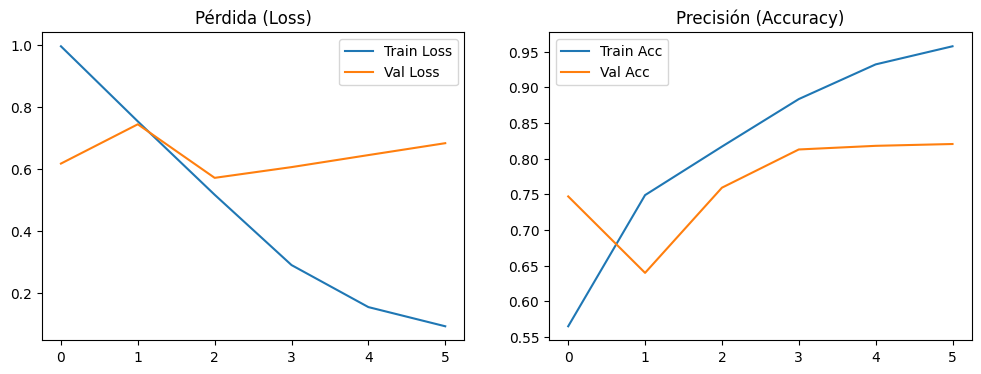

In [8]:
# Se muestra la pérdida y la precisión
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Pérdida (Loss)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Precisión (Accuracy)')
plt.legend()
plt.show()

Generando Predicciones para Reporte
123/123 [==============================] - 18s 139ms/step
                      precision    recall  f1-score   support

Not Recommended (-1)       0.55      0.21      0.30       124
  Mixed Feelings (0)       0.32      0.52      0.39       201
     Recommended (1)       0.93      0.90      0.92      1636

            accuracy                           0.82      1961
           macro avg       0.60      0.55      0.54      1961
        weighted avg       0.85      0.82      0.83      1961



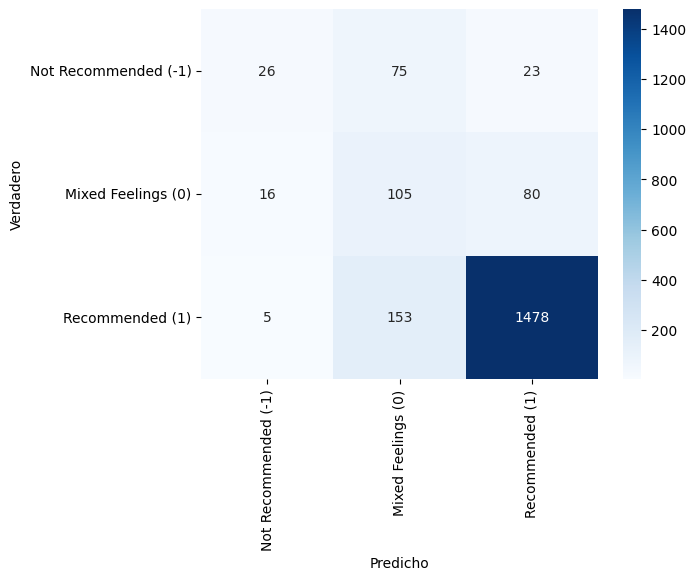

In [9]:
print("Generando Predicciones para Reporte")

# Se obtienen las predicciones
pred_logits = model.predict(test_dataset).logits
# Se aplica softmax para obtener probabilidades
y_pred_probs = tf.nn.softmax(pred_logits, axis=-1).numpy()
# Se obtiene la clase ganadora
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Nombres de etiquetas originales
class_names = ['Not Recommended (-1)', 'Mixed Feelings (0)', 'Recommended (1)']

print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Se muestra la matriz de confusión
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.show()

In [10]:
# Se guarda el modelo (formato específico de Hugging Face)
model.save_pretrained('/content/drive/MyDrive/Colab Notebooks/TFM/modelo_transformer_tfm')
print("Modelo guardado")

Modelo guardado
